In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression


## Data analysis

In [46]:
df = pd.read_csv('test.csv')
#df = pd.read_csv('test.csv')
#print(df.isna().sum())

df['Embarked'] = df['Embarked'].fillna('S')
df['Title'] = df['Name'].str.extract(r',\s*([^\.]*)\.', expand=False)
title_mapping = {
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Miss': 'Miss',
    'Master': 'Master',
    'Mlle': 'Miss',     # French for Miss
    'Ms': 'Miss',
    'Mme': 'Mrs',       # French for Mrs
    'Lady': 'Mrs',
    'Countess': 'Mrs',
    'Dona': 'Mrs',
    'Sir': 'Mr',
    'Jonkheer': 'Mr',
    'Don': 'Mr',
    'Rev': 'Mr',
    'Dr': 'Mr',
    'Col': 'Mr',
    'Major': 'Mr',
    'Capt': 'Mr'
}
df['Title'] = df['Title'].map(title_mapping).fillna('Mrs')
df['Deck'] = df['Cabin'].str[0]
df['Deck'] = df['Deck'].replace('T', 'U')
df['Deck'] = df['Deck'].fillna('U')
df = df.drop(['Cabin'], axis=1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,U
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,U
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,U
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,U
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,U


In [52]:
known_age = df[df['Age'].notnull()]
y_known = known_age['Age']
known_age = known_age.drop(columns=['Name', 'Age'])
unknown_age = df[df['Age'].isnull()]
unknown_age = unknown_age.drop(columns=['Name', 'Age'])
print(known_age.shape)
print(unknown_age.shape)
known_age.head()

(332, 11)
(86, 11)


,PassengerId,Pclass,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
0,892,3,male,0,0,330911,7.8292,NaN,Q,Mr,U
1,893,3,female,1,0,363272,7.0000,NaN,S,Mrs,U
2,894,2,male,0,0,240276,9.6875,NaN,Q,Mr,U
3,895,3,male,0,0,315154,8.6625,NaN,S,Mr,U
4,896,3,female,1,1,3101298,12.2875,NaN,S,Mrs,U


In [55]:
features = ['Pclass','Sex','SibSp','Parch','Ticket','Embarked','Fare','Title','Deck']
numerical = ['SibSp','Parch','Fare']
categorical = ['Pclass', 'Sex', 'Embarked','Title','Deck']
column_transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False),categorical), 
    (StandardScaler(), numerical),
    remainder = 'passthrough')

In [57]:
column_transformer.fit(known_age[features])
X_known = column_transformer.transform(known_age[features])
X_missing = column_transformer.transform(unknown_age[features])
print(X_missing.shape)
print(X_known.shape)

(86, 24)
(332, 24)


### using linear regression to fill the age null values 

In [28]:
from sklearn.linear_model import LinearRegression
#making and fitting the model 
lg = LinearRegression(positive=True)




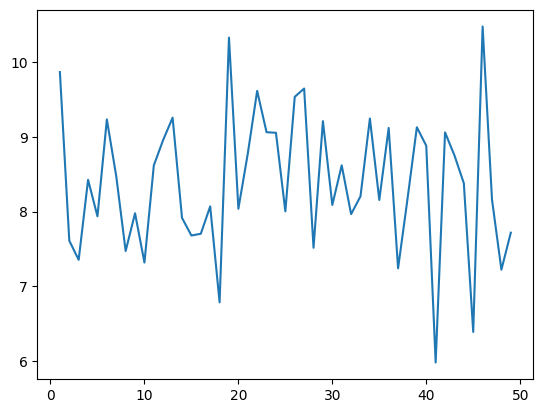

In [29]:
error = []
seeds = range(1,50)
for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.1, random_state = seed)
    lg.fit(X_train, y_train)
    #making the prediction
    y_pred = lg.predict(X_test)
    error.append(mean_absolute_error(y_test, y_pred))

plt.plot(seeds, error)
plt.show()

In [30]:
#split the data using random_state = 2
X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.1, random_state = 2)

lg.fit(X_train, y_train)
#making the prediction
y_pred = lg.predict(X_test)
#testing accuracy by finding mean absolute error
MAE = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)
print(MAE)

10.129345586438562
7.612073470710857


### Using random forest regressor

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [10]:
# error = []
# seeds = range(1,30)
# for seed in seeds:
#     rfr = RandomForestRegressor(random_state=seed)
#     X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state = 2)
#     rfr.fit(X_train, y_train)
#     y_pred = rfr.predict(X_test) 
#     error.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# plt.plot(seeds, error)
# plt.ylabel('MSE')
# plt.xlabel('seeds')
# plt.show()

In [32]:
rfr = RandomForestRegressor(
    random_state=6
)
X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state = 5)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
MAE = np.sqrt(mean_squared_error(y_test, y_pred))
MAE

np.float64(11.513647417233434)

### comparing with a naive model

In [45]:
median_age = known_age['Age'].median()
baseline_preds = [median_age] * len(known_age)
baseline_rmse = np.sqrt(mean_squared_error(y_known, baseline_preds))
baseline_rmse

np.float64(14.43808906018971)

### use the random forest regressor to determine the missing ages

In [35]:
#predicting missing null values in the age column
predicted_ages = rfr.predict(X_missing)
predicted_ages
ndf.loc[df['Age'].isnull(), 'Age'] = predicted_ages

In [36]:
ndf.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
Deck           0
dtype: int64

### determining if age is a good factor.

In [ ]:
survived_females = df.loc[(df['Survived'] == 1) & (df['Sex'] == 'female')]

counts, bins, patches = plt.hist(survived_females['Age'])
plt.xticks(bins)
plt.xlabel('Age range')
plt.ylabel('Number of females survived')
plt.title('Survival rate of females according to their age')
plt.show()


In [ ]:
survived_males = df.loc[(df['Survived'] == 1) & (df['Sex'] == 'male')]

counts, bins, patches = plt.hist(survived_males['Age'])
plt.xticks(bins)
plt.xlabel('Age range')
plt.ylabel('Number of males survived')
plt.title('Survival rate of males according to their age')
plt.show()


####  it is clear that teens and middle aged females (13-38) had the highest probability of survival while only middle aged males (24-32) had a higher chance of survival, overall males were at a disadvantage. 

## Data preping

In [37]:

ndf['AgeGroup'] = pd.cut(ndf['Age'], bins=[0, 12, 18, 35, 60, 80], labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])
ndf.head()
ndf.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
Deck           0
AgeGroup       0
dtype: int64

In [19]:

log = LogisticRegression(solver='lbfgs')
features = ['Pclass','Sex','Age','SibSp','Parch','Embarked','Fare','Title','Deck']
numerical = ['SibSp','Parch','Age','Fare']
categorical = ['Pclass', 'Sex', 'Embarked','Title','Deck']
X = ndf[features]
y = ndf['Survived']
prep = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore', sparse_output=False),categorical), 
    (StandardScaler(), numerical),
    remainder = 'passthrough')
model = make_pipeline(prep, log)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=24)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
metrics.accuracy_score(y_test,y_pred)

0.8212290502793296

In [ ]:
model = Titanic.TitanicModel()
model.fit(ndf)
y_pred = model.predict()
model.score()

In [ ]:
y.value_counts(normalize=True)

In [44]:
features

['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Fare', 'Title', 'Deck']